In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Load the Validation and Training Data stored in HDF5 format

In [2]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
#import os
#os.getcwd()
import cv2
import random

import custom_batch_generator_hpf5

batch_size = 8

ValImgPath = "ValidationImages.h5"
ValMskPath = "ValidationMasks.h5"
ValmDG = custom_batch_generator_hpf5.myDataGenerator(ValImgPath, ValMskPath, batch_size)

TrainImgPath = "TrainImages.h5"
TrainMskPath = "TrainMasks.h5"
TrainmDG = custom_batch_generator_hpf5.myDataGenerator(TrainImgPath, TrainMskPath, batch_size)

print("number of batchs: {}".format(len(TrainmDG)))

OSError: Unable to open file (unable to open file: name = 'ValidationImages.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Download pretrained denseNet from Keras applications, to be used as base model 

In [3]:
import keras.applications
import keras.layers as kl

# Initialize a Model
net_input = kl.Input(shape=(224,224,3))
#net_model = keras.applications.densenet.DenseNet121(weights='imagenet', include_top = False, input_tensor=net_input)
densenet_as_base_model = keras.applications.densenet.DenseNet201(weights='imagenet', include_top = False,input_tensor=net_input)

# Freeze weights of base model for first few epochs
densenet_as_base_model.trainable = False

densenet_as_base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Add Unet style connections on top-of the DenseNet

In [4]:
from keras.models import Model

def createModel(my_base_model):
    numfilters = 128
    gnoise = 0.001
    
    net_model = my_base_model
    netIn = net_model.output
    
    # Add layer on top of base model
    
    #up0 = kl.UpSampling2D((2,2))(net)
    up0 = kl.Conv2DTranspose(numfilters, (3, 3), strides=(2, 2), padding='same')(netIn)
    up0 = kl.BatchNormalization()(up0)
    up0 = kl.GaussianNoise(gnoise)(up0)
    up0 = kl.Activation('elu')(up0)
    skip = kl.Conv2D(numfilters, (1,1), padding='same')(net_model.get_layer("pool4_relu").output)
    skip = kl.BatchNormalization()(skip)
    skip = kl.Activation('elu')(skip)
    up = kl.Concatenate(axis=3)([up0, skip])
    #up = up0
    up = kl.SpatialDropout2D(0.5,data_format='channels_last')(up)
    up = kl.Conv2D(numfilters, (3,3), padding='same', name='up1a')(up)
    up = kl.BatchNormalization()(up)
    up = kl.GaussianNoise(gnoise)(up)
    up = kl.Activation('elu')(up)
    up = kl.Conv2D(numfilters, (3,3), padding='same', name='up1b')(up)
    up = kl.BatchNormalization()(up)
    up = kl.GaussianNoise(gnoise)(up)
    up = kl.Activation('elu')(up)

    #up1 = kl.UpSampling2D((2,2))(up)
    up1 = kl.Conv2DTranspose(numfilters/2, (3, 3), strides=(2, 2), padding='same')(up)
    up1 = kl.BatchNormalization()(up1)
    up1 = kl.GaussianNoise(gnoise)(up1)
    up1 = kl.Activation('elu')(up1)
    skip = kl.Conv2D(numfilters/2, (1,1), padding='same')(net_model.get_layer("pool3_relu").output)
    skip = kl.BatchNormalization()(skip)
    skip = kl.Activation('elu')(skip)
    up = kl.Concatenate(axis=3)([up1, skip])
    #up = up1
    #up = kl.SpatialDropout2D(0.5,data_format='channels_last')(up)
    up = kl.Conv2D(numfilters/2, (3,3), padding='same', name='up2a')(up)
    up = kl.BatchNormalization()(up)
    up = kl.GaussianNoise(gnoise)(up)
    up = kl.Activation('elu')(up)
    up = kl.Conv2D(numfilters/2, (3,3), padding='same', name='up2b')(up)
    up = kl.BatchNormalization()(up)
    up = kl.GaussianNoise(gnoise)(up)
    up = kl.Activation('elu')(up)

    #up2 = kl.UpSampling2D((2,2))(up)
    up2 = kl.Conv2DTranspose(numfilters/4, (3, 3), strides=(2, 2), padding='same')(up)
    up2 = kl.BatchNormalization()(up2)
    up2 = kl.GaussianNoise(gnoise)(up2)
    up2 = kl.Activation('elu')(up2)
    skip = kl.Conv2D(numfilters/4, (1,1), padding='same')(net_model.get_layer("pool2_relu").output)
    skip = kl.BatchNormalization()(skip)
    skip = kl.Activation('elu')(skip)
    up = kl.Concatenate(axis=3)([up2, skip])
    #up = kl.SpatialDropout2D(0.5,data_format='channels_last')(up)
    #up = up2
    up = kl.Conv2D(numfilters/4, (3,3), padding='same', name='up3a')(up)
    up = kl.BatchNormalization()(up)
    up = kl.GaussianNoise(gnoise)(up)
    up = kl.Activation('elu')(up)
    up = kl.Conv2D(numfilters/4, (3,3), padding='same', name='up3b')(up)
    up = kl.BatchNormalization()(up)
    up = kl.GaussianNoise(gnoise)(up)
    up = kl.Activation('elu')(up)

    #side = kl.Conv2D(numfilters/8, (1,1), padding='same', name='side1')(net_model.get_layer("conv1/relu").output)
    #side = kl.BatchNormalization()(side)
    #side = kl.GaussianNoise(gnoise)(side)
    #side = kl.Activation('elu')(side)
    #side = kl.Conv2D(numfilters/8, (3,3), padding='same', name='side2')(side)
    #side = kl.BatchNormalization()(side)
    #side = kl.GaussianNoise(gnoise)(side)
    #side = kl.Activation('elu')(side) 

    #up3 = kl.UpSampling2D((2,2))(up)
    up3 = kl.Conv2DTranspose(numfilters/8, (3, 3), strides=(2, 2), padding='same')(up)
    up3 = kl.BatchNormalization()(up3)
    up3 = kl.GaussianNoise(gnoise)(up3)
    up3 = kl.Activation('elu')(up3)
    #up = kl.Concatenate(axis=3)([up3, side])
    #up = kl.SpatialDropout2D(0.5,data_format='channels_last')(up3)
    up = up3
    up = kl.Conv2D(numfilters/8, (3,3), padding='same', name='up4a')(up)
    up = kl.BatchNormalization()(up)  
    up = kl.GaussianNoise(gnoise)(up) 
    up = kl.Activation('elu')(up)
    up = kl.Conv2D(numfilters/8, (3,3), padding='same', name='up4b')(up)
    up = kl.BatchNormalization()(up)
    up = kl.GaussianNoise(gnoise)(up)
    up = kl.Activation('elu')(up)

    #side = kl.Conv2D(numfilters/8, (3,3), padding='same', name='side1')(net_model.get_layer("input_1").output)
    #side = kl.BatchNormalization()(side)
    #side = kl.Activation('elu')(side)
    #side = kl.Conv2D(numfilters/8, (3,3), padding='same', name='side2')(side)
    #side = kl.BatchNormalization()(side)
    #side = kl.Activation('elu')(side)

    #up4 = kl.UpSampling2D((2,2))(up)
    up4 = kl.Conv2DTranspose(numfilters/16, (3, 3), strides=(2, 2), padding='same')(up)
    up4 = kl.BatchNormalization()(up4)
    up4 = kl.GaussianNoise(gnoise)(up4)
    up4 = kl.Activation('elu')(up4)
    #up = kl.Concatenate(axis=3)([up4, side, kl.UpSampling2D((16,16))(up0), kl.UpSampling2D((8,8))(up1), kl.UpSampling2D((4,4))(up2),kl.UpSampling2D((2,2))(up3)])
    #up = kl.SpatialDropout2D(0.5,data_format='channels_last')(up4)
    up = up4
    up = kl.Conv2D(numfilters/16, (3,3), padding='same', name='up5a')(up)
    up = kl.BatchNormalization()(up)
    up = kl.Activation('elu')(up)
    up = kl.Conv2D(numfilters/16, (3,3), padding='same', name='up5b')(up)
    bn0 = kl.BatchNormalization()(up)
    top = kl.Activation('elu')(bn0)
    #up = kl.SpatialDropout2D(0.5,data_format='channels_last')(up)

    outnet = kl.Conv2D(1, (1,1), padding='same', name='segout')(top)
    #outnet = kl.BatchNormalization()(outnet)
    outnet = kl.Activation('sigmoid')(outnet)

    # model creation
    denseUnet = Model(my_base_model.input, outnet, name="dense_unet")
    
    return denseUnet

In [5]:
LaneSegModel = createModel(densenet_as_base_model)
LaneSegModel.summary()

Model: "dense_unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________________________________________________________________________________________

Total params: 21,493,297
Trainable params: 3,169,377
Non-trainable params: 18,323,920
__________________________________________________________________________________________________


## Define loss, accuracy and callback functions to be used during training

In [6]:
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib
# Specifying the backend to be used before importing pyplot
# to avoid "RuntimeError: Invalid DISPLAY variable"
#matplotlib.use('agg')
import matplotlib.pyplot as plt

tf.to_float = lambda x: tf.cast(x, tf.float32)
def iou_coef(y_true, y_pred):
    y_pred_class = tf.to_float(y_pred > 0.5)

    correct_prediction = tf.equal(y_pred_class, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tp = tf.reduce_sum(y_pred_class * y_true)
    fp = tf.reduce_sum(tf.nn.relu(y_pred - y_true))
    fn = tf.reduce_sum(tf.nn.relu(y_true - y_pred))

    iou = tp / (tp + fp + fn)
    return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


saveModelPath = "/home/calm/Documents/lane segmentation/model/LanesegDenseUnet.h5"
checkpointer = ModelCheckpoint(saveModelPath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)


## Compile and tain Road Segmentation network (or DenseUNet)

In [7]:
import tensorflow as tf
LaneSegModel.compile(
      optimizer=tf.keras.optimizers.RMSprop(),
      loss=soft_dice_loss,
      metrics=[iou_coef])

### Train for few epochs (4) freezing the weights of base network

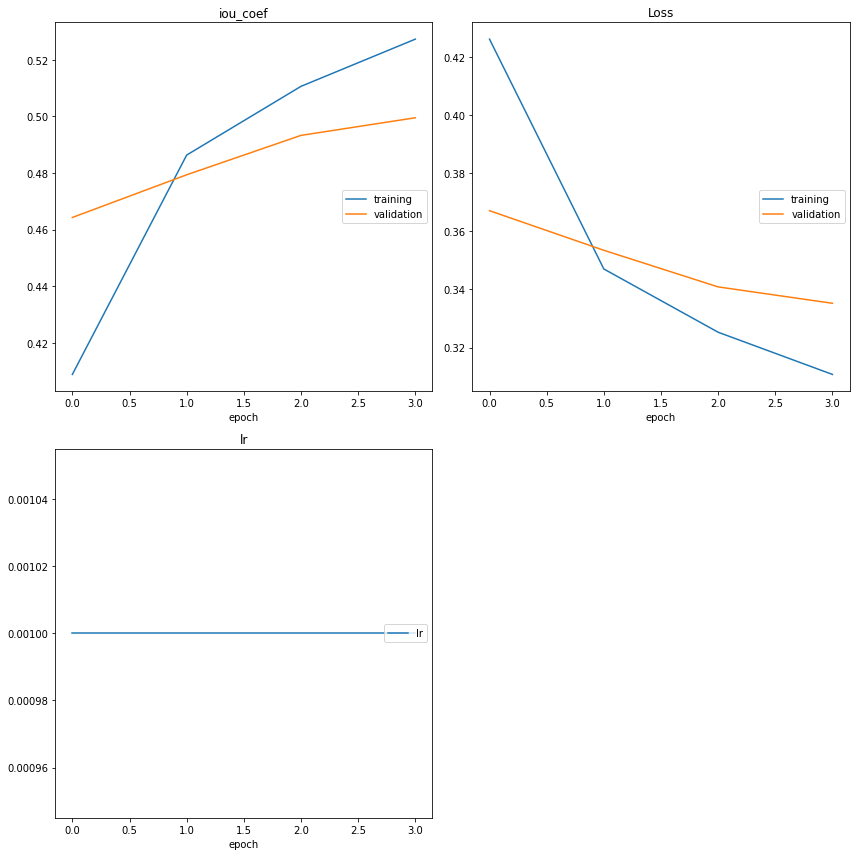

iou_coef
	training         	 (min:    0.409, max:    0.527, cur:    0.527)
	validation       	 (min:    0.464, max:    0.499, cur:    0.499)
Loss
	training         	 (min:    0.311, max:    0.426, cur:    0.311)
	validation       	 (min:    0.335, max:    0.367, cur:    0.335)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
4347/4347 [==============================] - 417s 96ms/step - loss: 0.3108 - iou_coef: 0.5273 - val_loss: 0.3353 - val_iou_coef: 0.4995


In [8]:
from livelossplot import PlotLossesKeras
history1 = LaneSegModel.fit(x=TrainmDG,
                            validation_data=ValmDG,
                            steps_per_epoch= len(TrainmDG),
                            epochs = 4,
                            callbacks = [checkpointer, earlystopper, lr_reducer, PlotLossesKeras()])

In [9]:
LaneSegModel.save("/home/calm/Documents/lane segmentation/model/model_epoch4")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/calm/Documents/lane segmentation/model/model_epoch4/assets


### Unfreeze weights of base model and start training for 60 Epochs

In [10]:

densenet_as_base_model.trainable = True

In [12]:
# Recompile is needed
LaneSegModel.compile(
      optimizer=tf.keras.optimizers.RMSprop(),
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [13]:
checkpointer_new = ModelCheckpoint(filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5",
                             monitor="val_loss",
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min',
                             verbose=1)


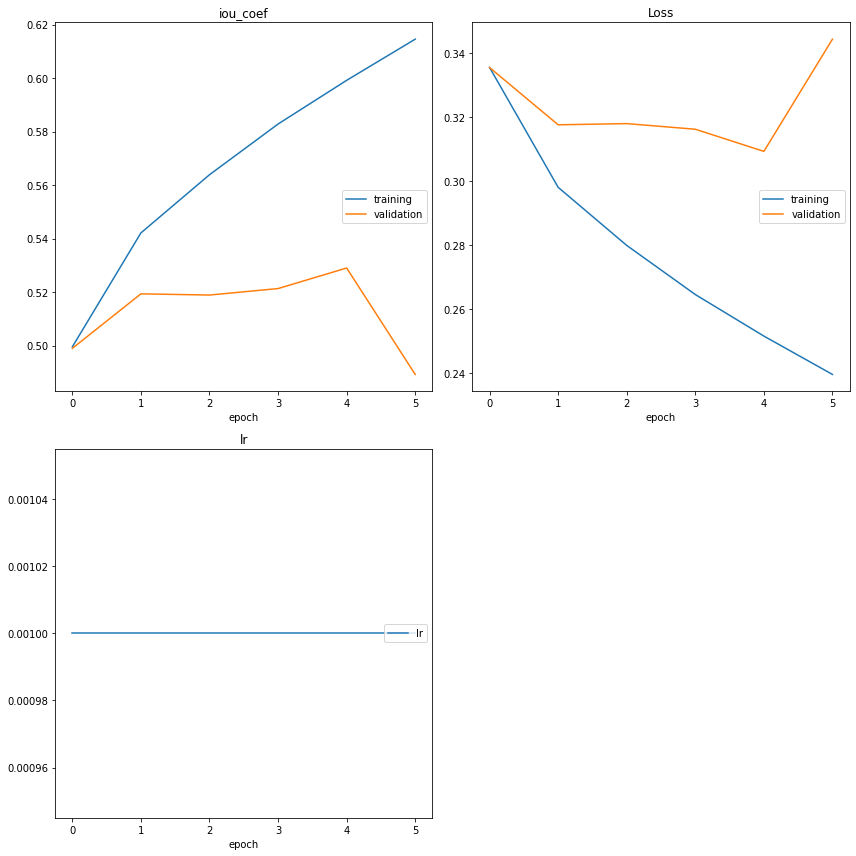

iou_coef
	training         	 (min:    0.500, max:    0.615, cur:    0.615)
	validation       	 (min:    0.489, max:    0.529, cur:    0.489)
Loss
	training         	 (min:    0.240, max:    0.336, cur:    0.240)
	validation       	 (min:    0.309, max:    0.344, cur:    0.344)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
4347/4347 [==============================] - 933s 215ms/step - loss: 0.2396 - iou_coef: 0.6145 - val_loss: 0.3444 - val_iou_coef: 0.4892
Epoch 7/60
3774/4347 [=========================>....] - ETA: 2:00 - loss: 0.2277 - iou_coef: 0.6302

In [ ]:
history2 = LaneSegModel.fit(x=TrainmDG,
                            validation_data=ValmDG,
                            steps_per_epoch= len(TrainmDG),
                            epochs = 60,
                            callbacks = [checkpointer_new, earlystopper, lr_reducer, PlotLossesKeras()])

### Training halted due to early_stop creiteria. Training again using no early_stopping

In [ ]:
history3 = LaneSegModel.fit(x=TrainmDG,
                            validation_data=ValmDG,
                            steps_per_epoch= len(TrainmDG),
                            epochs = 30,
                            callbacks = [checkpointer_new, lr_reducer, PlotLossesKeras()])

In [ ]:
LaneSegModel.save("/home/ajit/Documents/proj")

In [ ]:
session.close()